# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook') 
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8) 

In [2]:
df = pd.read_csv('data/spam_or_not_spam.zip')
df

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [3]:
df['label'].value_counts().to_frame()

,count
label,
0,2500
1,500


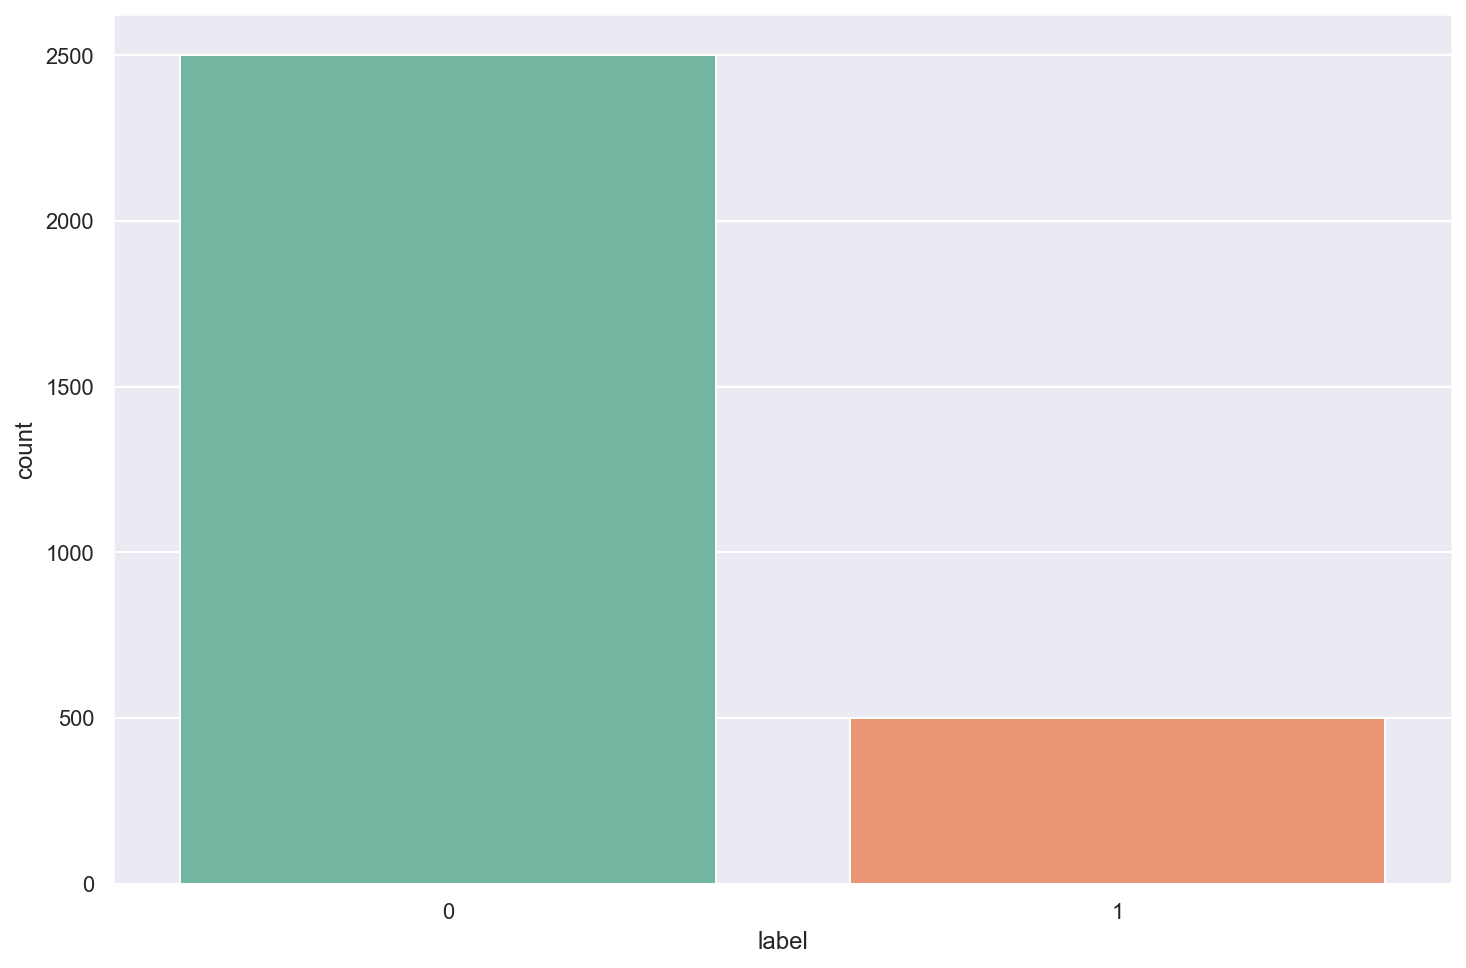

In [4]:
sns.countplot(data=df, x='label');

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [5]:
# вручную удалять проблелы и менять регистр не нужно, это делает CountVectorizer

# ^ is the start of the string anchor.
# \s is the regex pattern for whitespace character.
# * means zero or more of the preceding element, in this case, a whitespace character.
# $ is the end of the string anchor.
df['email'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['email'])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
X.shape

(2997, 34116)

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [9]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [10]:
y_test.mean()

0.16533333333333333

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [11]:
alpha = 0.01
mnb = MultinomialNB(alpha=alpha)
cnb = ComplementNB(alpha=alpha)

models = {'MultinomialNB': mnb, 'ComplementNB': cnb}

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [12]:
for name, model in models.items():
    print('Model:', name)
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('****TRAIN****')
    print(f'Accuracy: {accuracy_score(y_train, y_train_pred):.3f}')
    print(f'Precision: {precision_score(y_train, y_train_pred):.3f}')
    print(f'Recall: {recall_score(y_train, y_train_pred):.3f}')
    print(f'F1_score: {f1_score(y_train, y_train_pred):.3f}')
    print()
    
    print('****TEST****')
    print(f'Accuracy: {accuracy_score(y_test, y_test_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_test_pred):.3f}')
    print(f'Recall: {recall_score(y_test, y_test_pred):.3f}')
    print(f'F1_score: {f1_score(y_test, y_test_pred):.3f}')
    print()

Model: MultinomialNB
****TRAIN****
Accuracy: 0.999
Precision: 1.000
Recall: 0.995
F1_score: 0.997

****TEST****
Accuracy: 0.987
Precision: 1.000
Recall: 0.919
F1_score: 0.958

Model: ComplementNB
****TRAIN****
Accuracy: 1.000
Precision: 1.000
Recall: 0.997
F1_score: 0.999

****TEST****
Accuracy: 0.988
Precision: 1.000
Recall: 0.927
F1_score: 0.962



Модель ComplementNB показывает улучшение метрик на тестовой выборке, дальше использую ее

Нарисуйте ROC-кривую:

In [13]:
model = ComplementNB(alpha=alpha)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

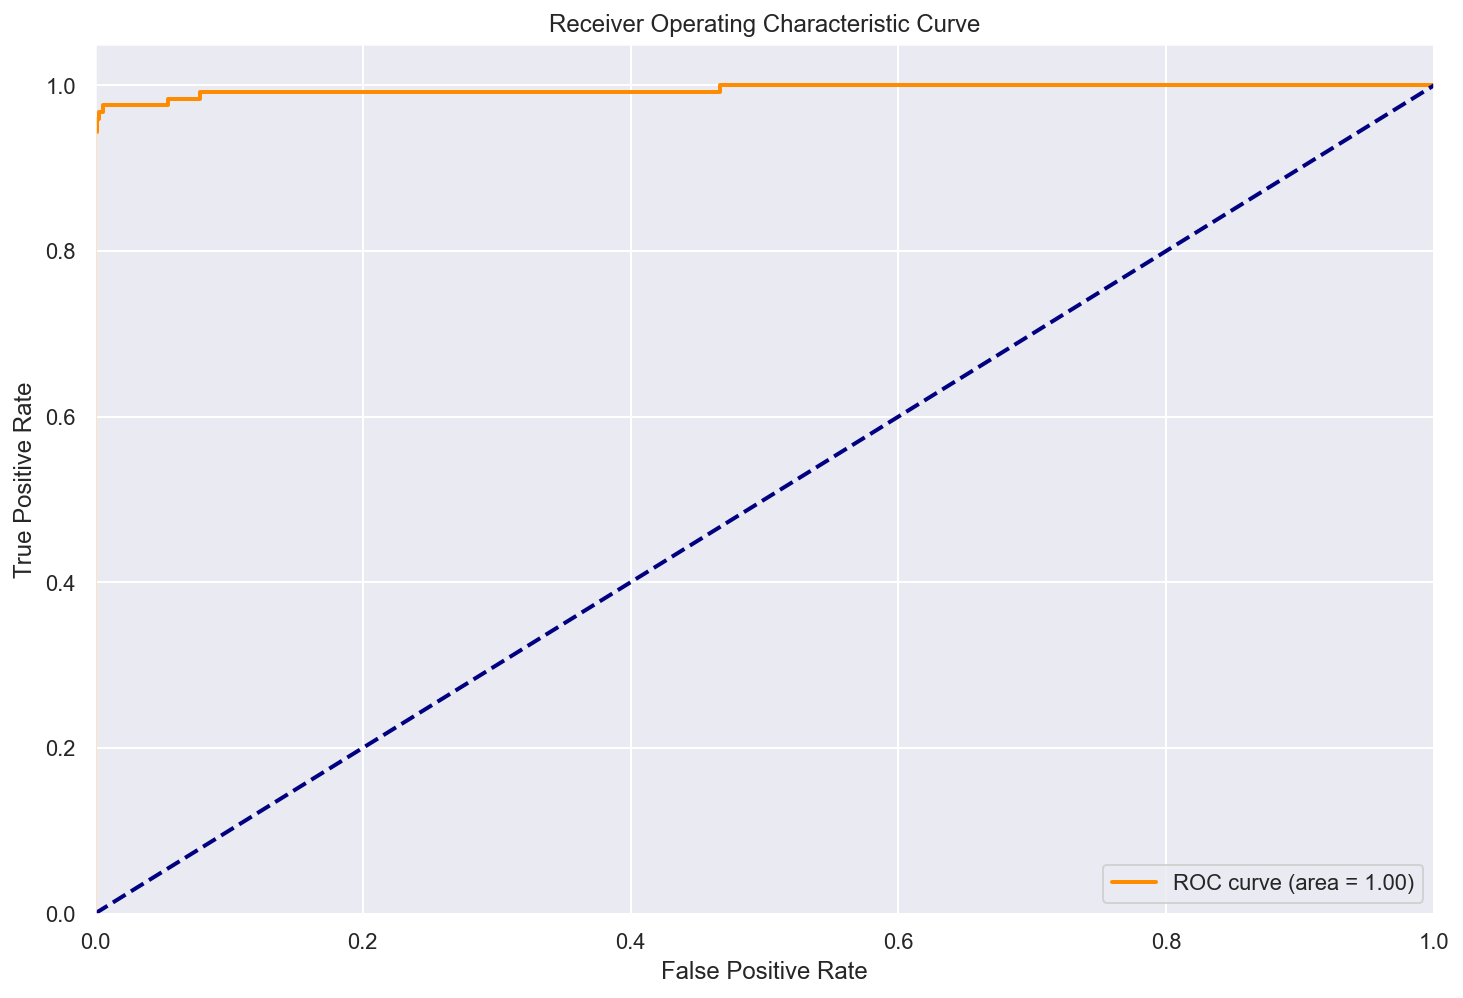

In [14]:
# получаю предсказание вероятностей принадлежности классу 1
y_score = model.predict_proba(X_test)[:, 1]

# вычисляю ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [15]:
# Определяю сетку гиперпараметров
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]}

# создаю объект поиска по сетке
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, # кросс-валидатор
    scoring='roc_auc', # метрика
    return_train_score=False, # подсчёт метрики на тренировочных фолдах
    n_jobs=-1
)

print('***Модель ComplementNB***')
# обучаю модель
grid_search.fit(X_train, y_train)
print(f'Наилучшие значения гиперпараметров полученные на кросс-валидации: {grid_search.best_params_}')
print(f'Среднее наилучшее значение метрики roc_auc на тестовых фолдах кросс-валидации: {grid_search.best_score_:.4f}')
print()

print('****TEST****')
y_test_pred = grid_search.predict(X_test)    
print(f'Accuracy: {accuracy_score(y_test, y_test_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_test_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_test_pred):.3f}')
print(f'F1_score: {f1_score(y_test, y_test_pred):.3f}')

***Модель ComplementNB***


Наилучшие значения гиперпараметров полученные на кросс-валидации: {'alpha': 0.5}
Среднее наилучшее значение метрики roc_auc на тестовых фолдах кросс-валидации: 0.9883

****TEST****
Accuracy: 0.995
Precision: 0.992
Recall: 0.976
F1_score: 0.984


На тестовой выборке при подобранном параметре appha=0.5 выросли значения

Было:
* Accuracy: 0.995
* Recall: 0.927
* F1_score: 0.962

Precision немного cнизился.